In [26]:
### import packages
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier, IslationForest, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X = {'target':'drive/MyDrive/self/Train-1542865627584.csv',
    'beneficiary':'drive/MyDrive/self/Train_Beneficiarydata-1542865627584.csv',
    'in_pt':'drive/MyDrive/self/Train_Inpatientdata-1542865627584.csv',
    'out_pt': 'drive/MyDrive/self/Train_Outpatientdata-1542865627584.csv'}

In [19]:
def finalprediction(X):
  ############
  #reading the input
  target= pd.read_csv(X['target'])
  beneficiary=pd.read_csv(X['beneficiary'])
  in_pt=pd.read_csv(X['in_pt'])
  out_pt=pd.read_csv(X['out_pt'])
  ##merging the data
  merged_data = pd.merge(in_pt, out_pt,left_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                        right_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                        how = 'outer').\
              merge(beneficiary,left_on='BeneID',right_on='BeneID',how='inner')
  
  fraud_provider_ip_df = pd.merge(merged_data,target, how='inner', on='Provider')
  ##physian
  #######
  fraud_provider_ip_df['AttendingPhysician']= fraud_provider_ip_df['AttendingPhysician'].replace(np.nan,0, regex=True)
  fraud_provider_ip_df['OperatingPhysician']= fraud_provider_ip_df['OperatingPhysician'].replace(np.nan,0, regex=True)
  fraud_provider_ip_df['OtherPhysician'] = fraud_provider_ip_df['OtherPhysician'].replace(np.nan, 0, regex=True)
  fraud_provider_ip_df['numberofdoctor'] = fraud_provider_ip_df[["AttendingPhysician","OperatingPhysician","OtherPhysician"]].apply(lambda x:x.unique().tolist(), axis=1)
  
  for sentance in (fraud_provider_ip_df['numberofdoctor'].values):
        for i in sentance:
            if i==0:
                sentance.remove(0)
  fraud_provider_ip_df['uniquenumberofdoctor'] = fraud_provider_ip_df["numberofdoctor"].str.len()
  #############################
  #fraud state
  Train_fyes = fraud_provider_ip_df.loc[(fraud_provider_ip_df['PotentialFraud'] == 'Yes')]
  fraudyes=Train_fyes['State'].value_counts()
  fraudyes = fraudyes.to_frame()
  fraudyes['count']=fraudyes['State']
  fraudyes['number'] = fraudyes.index
  fraudyes=fraudyes.drop(['State'],axis=1)
  lst1=fraudyes['count']
  lst3=fraudyes['number']
  statelabels = lst3
  fraudyes = lst1
  statecode=statelabels[:15]
 ######## print(statecode)
  fraudstate=[]
  for code in (fraud_provider_ip_df['State'].values):
    if code in statecode:
      fraudstate.append(1)
    else:
      fraudstate.append(0)
  fraud_provider_ip_df['fraudstate']=fraudstate
  #####################################################
  ########fraud country
  Train_fyes = fraud_provider_ip_df.loc[(fraud_provider_ip_df['PotentialFraud'] == 'Yes')]
  fraudyes=Train_fyes['County'].value_counts()
  fraudyes = fraudyes.to_frame()
  fraudyes['count']=fraudyes['County']
  fraudyes['number'] = fraudyes.index
  fraudyes=fraudyes.drop(['County'],axis=1)
  lst1=fraudyes['count']
  lst3=fraudyes['number']
  countrylabels = lst3[:20]
  fraudyes = lst1[:20]
  countrycode=countrylabels[:15]
  fraudcountry=[]
  for code in (fraud_provider_ip_df['County'].values):
    if code in countrycode:
      fraudcountry.append(1)
    else:
      fraudcountry.append(0)
  fraud_provider_ip_df['fraudcountry']=fraudcountry
  ######################################################
  #admit status
  fraud_provider_ip_df['AdmissionDt'] = fraud_provider_ip_df['AdmissionDt'].replace(np.nan, 0)
  
  def admission(df):
    lst=[]
    for i in (df):
        if i==0:
            lst.append(0)
        else:
            lst.append(1)
    return(lst)
  
  mn=admission(fraud_provider_ip_df['AdmissionDt'])
  fraud_provider_ip_df['isadmitted']=mn
  #discharge
  fraud_provider_ip_df['DischargeDt'] = fraud_provider_ip_df['DischargeDt'].replace(np.nan, 0)
  mn1=admission(fraud_provider_ip_df['DischargeDt'])
  fraud_provider_ip_df['isdischarge']=mn1
  ############################
  #admitted days

  fraud_provider_ip_df['DischargeDt'] = pd.to_datetime(fraud_provider_ip_df['DischargeDt'] , format = '%Y-%m-%d')
  fraud_provider_ip_df['AdmissionDt'] = pd.to_datetime(fraud_provider_ip_df['AdmissionDt'],format = '%Y-%m-%d',errors='ignore')

  fraud_provider_ip_df['admitteddays'] = round(((fraud_provider_ip_df['DischargeDt'] -fraud_provider_ip_df['AdmissionDt']).dt.days))

  ##difference between claim and procedural code
  fraud_provider_ip_df[[ 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']] = np.where(fraud_provider_ip_df[[ 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10',]].isnull(), 0, 1)


  fraud_provider_ip_df[['ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6']] = np.where(fraud_provider_ip_df[[ 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6']].isnull(), 0, 1)
  fraud_provider_ip_df['totaldiagnosiscode']=fraud_provider_ip_df['ClmDiagnosisCode_1']+fraud_provider_ip_df['ClmDiagnosisCode_2']+fraud_provider_ip_df['ClmDiagnosisCode_3']+fraud_provider_ip_df['ClmDiagnosisCode_4']+fraud_provider_ip_df['ClmDiagnosisCode_5']+fraud_provider_ip_df['ClmDiagnosisCode_6']+fraud_provider_ip_df['ClmDiagnosisCode_7']+fraud_provider_ip_df['ClmDiagnosisCode_8']+fraud_provider_ip_df['ClmDiagnosisCode_9']+fraud_provider_ip_df['ClmDiagnosisCode_10']
  fraud_provider_ip_df['totalproceduralcode']=fraud_provider_ip_df['ClmProcedureCode_1']+fraud_provider_ip_df['ClmProcedureCode_2']+fraud_provider_ip_df['ClmProcedureCode_3']+fraud_provider_ip_df['ClmProcedureCode_4']+fraud_provider_ip_df['ClmProcedureCode_5']+fraud_provider_ip_df['ClmProcedureCode_6']
  fraud_provider_ip_df['difference']=abs(fraud_provider_ip_df['totaldiagnosiscode']-fraud_provider_ip_df['totalproceduralcode'])
  ################
  #deductable amount status
  fraud_provider_ip_df['DeductibleAmtPaid'] = fraud_provider_ip_df['DeductibleAmtPaid'].replace(np.nan, 0)
  def deductable(df):
    lst=[]
    for i in (df):
        if i==0:
            lst.append(0)
        else:
            lst.append(1)
    return(lst)
  mn2=deductable(fraud_provider_ip_df['DeductibleAmtPaid'])
  fraud_provider_ip_df['isductable']=mn2 

  ###############
  ###same code or not
  fraud_provider_ip_df['DiagnosisGroupCode'] = fraud_provider_ip_df['DiagnosisGroupCode'].replace(np.nan, 0)
  fraud_provider_ip_df['ClmAdmitDiagnosisCode'] = fraud_provider_ip_df['ClmAdmitDiagnosisCode'].replace(np.nan, 0)
  fraud_provider_ip_df['issamecode'] = np.where((fraud_provider_ip_df['DiagnosisGroupCode'] == fraud_provider_ip_df['ClmAdmitDiagnosisCode']), 1, 0)
  ################
  #number of disease
  ##Replacing 2 with 0 for chronic conditions ,that means chroniv condition No is 0 and yes is 1

  fraud_provider_ip_df = fraud_provider_ip_df.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)
  fraud_provider_ip_df=fraud_provider_ip_df.replace({'RenalDiseaseIndicator': 'Y'}, 1)

  diseases=['ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease', 'ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke']  
  fraud_provider_ip_df['suffering']=fraud_provider_ip_df[diseases].sum(axis = 1)
  ##################
  ####claimtime
  fraud_provider_ip_df['ClaimEndDt'] = pd.to_datetime(fraud_provider_ip_df['ClaimEndDt'], format = '%Y-%m-%d')
  fraud_provider_ip_df['ClaimStartDt'] = pd.to_datetime(fraud_provider_ip_df['ClaimStartDt'],format = '%Y-%m-%d',errors='ignore')

  fraud_provider_ip_df['claimtime'] =(fraud_provider_ip_df['ClaimEndDt'] -fraud_provider_ip_df['ClaimStartDt']).dt.days
  fraud_provider_ip_df.drop(['ClaimEndDt', 'ClaimStartDt'], axis=1, inplace=True)
  #######
  #age of patient
  fraud_provider_ip_df['DOB'] = pd.to_datetime(fraud_provider_ip_df['DOB'], format = '%Y-%m-%d')
  fraud_provider_ip_df['DOD'] = fraud_provider_ip_df['DOD'].fillna(datetime.today().strftime('%Y-%m-%d'))
  fraud_provider_ip_df['Age'] = round((pd.to_datetime(fraud_provider_ip_df['DOD']) - pd.to_datetime(fraud_provider_ip_df['DOB'])).dt.days/365)

  ############
  #amount
  fraud_provider_ip_df['moneygot']=fraud_provider_ip_df['InscClaimAmtReimbursed']-fraud_provider_ip_df['DeductibleAmtPaid']
  ####
  fraud_provider_ip_df['moneygotIP']=fraud_provider_ip_df['IPAnnualReimbursementAmt']-fraud_provider_ip_df['IPAnnualDeductibleAmt']
  ########
  fraud_provider_ip_df['moneygotOP']=fraud_provider_ip_df['OPAnnualReimbursementAmt']-fraud_provider_ip_df['OPAnnualDeductibleAmt']

  fraud_provider_ip_df.shape

  Train_Count = fraud_provider_ip_df[['BeneID', 'ClaimID']].groupby(fraud_provider_ip_df['Provider']).nunique().reset_index()

  Train_sum=fraud_provider_ip_df.groupby(['Provider'], as_index = False)[['ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'fraudstate', 'fraudcountry','isductable', 'issamecode','isadmitted', 'isdischarge']].sum()
  #https://www.kaggle.com/rahuly93/medicare-provider-fraud-detection
  Train_Data_mean = fraud_provider_ip_df.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid','admitteddays',
                                                    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_Cancer', 
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_ObstrPulmonary',
                                                   'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',   
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'IPAnnualReimbursementAmt','IPAnnualDeductibleAmt',
                                                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt','suffering','Age','moneygot','moneygotIP','moneygotOP',
                                                    'claimtime','totaldiagnosiscode','totalproceduralcode','difference','uniquenumberofdoctor','NoOfMonths_PartACov', 'NoOfMonths_PartBCov']].mean()

  Train_df=pd.merge(Train_Count,Train_Data_mean,on='Provider',how='left').\
                merge(Train_sum,on='Provider',how='left').\
                 merge(target,on='Provider',how='left')
  
      
  #####print(Train_df.shape)
  Train_df['PotentialFraud']=Train_df['PotentialFraud'].replace({'Yes':1, 'No':0})
  Train_df.to_csv('drive/MyDrive/self/newfile.csv')
  y=Train_df['PotentialFraud']
  provider=Train_df['Provider']
  X=Train_df.drop(['Provider','PotentialFraud'], axis = 1)

#############
  #divide data in k part
  def metadataset(k):
    yhat=[]
    yhattest=[]
    for i in range(k):
      t=i%6
      if t==0:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel1.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==1:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel2.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==2:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel3.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==3:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel4.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==4:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel5.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      else:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel6.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      #yhat.append(ypred)
      yhattest.append(ytest)
    return(np.transpose(yhattest))
  k=10
  # k is hyperparametr can be anything
  testmeta=metadataset(10)
  #trainmetay=numpy.array(ytrain2)
  #testmetay=numpy.array(y_test)
  
  
  filename = 'drive/MyDrive/self/bestmetaxgboost_model.sav'
  bestmeta= pickle.load(open(filename, 'rb'))
  prediction=bestmeta.predict(testmeta)
  prediction_df = pd.DataFrame()
  prediction_df['Provider_ID'] =provider
  prediction_df['prediction'] = prediction
    
  return(prediction_df)




In [20]:
finalprediction=finalprediction(X)
finalprediction.to_csv('drive/MyDrive/self/finalpreiction.csv')
finalprediction.head()


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  21 tasks  

,Provider_ID,prediction
0,PRV51001,0
1,PRV51003,1
2,PRV51004,0
3,PRV51005,1
4,PRV51007,0


In [43]:
def performence(X,y):
  """Performence of the model """
  
  def metadataset(k):
    yhat=[]
    yhattest=[]
    for i in range(k):
      t=i%6
      if t==0:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel1.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==1:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel2.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==2:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel3.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==3:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel4.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      elif t==4:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel5.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      else:
        #x,y=samplingdata()
        filename = 'drive/MyDrive/self/basemodel6.sav'
        model= pickle.load(open(filename, 'rb'))
        #ypred=model.predict(Xtrain2)
        ytest=model.predict(X)
      #yhat.append(ypred)
      yhattest.append(ytest)
    return(np.transpose(yhattest))
  k=10
  # k is hyperparametr can be anything
  testmeta=metadataset(10)
  #trainmetay=numpy.array(ytrain2)
  testmetay=numpy.array(y)
  
  filename = 'drive/MyDrive/self/bestmetaxgboost_model.sav'
  bestmeta= pickle.load(open(filename, 'rb'))
  print("score",bestmeta.score(testmeta,testmetay))

   
  def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
      if i>=threshould:
        predictions.append(1)
      else:
        predictions.append(0)
    return predictions


  def get_confusion_matrix(y, y_pred, best_t = 0.352):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_t(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'])
  
  
  y_pred_prob =bestmeta.predict_proba(testmeta)[:,1]   
  test_fpr, test_tpr, thresholds = roc_curve(y, y_pred_prob)

  pred_output=predict_with_best_t(y_pred_prob, threshould = 0.352)
  get_confusion_matrix(y, pred_output, best_t=0.352)
  plt.title("confusion matrix for test data")
  plt.show()

  actual_output = y
  model_f1_score = metrics.f1_score(actual_output,pred_output)
  print("Model test F1 score is : ",model_f1_score)
    
  model_AUC_score = metrics.auc(test_fpr, test_tpr)
  print("Model test AUC score is : ",model_AUC_score)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  21 tasks  

score 0.9360443622920518


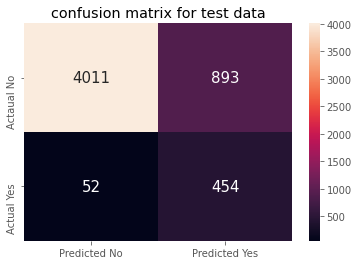

Model test F1 score is :  0.4900161899622234
Model test AUC score is :  0.9059209550645113


In [44]:
Train_df = pd.read_csv('drive/MyDrive/self/newfile.csv')
y=Train_df['PotentialFraud']
X=Train_df.drop(['Provider','PotentialFraud','Unnamed: 0'], axis = 1)
performence(X,y)